TODO:
Word clouds
Most frequent words in each decade


In [1]:
# Colab setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initialize Parameters

In [2]:
PARENT_DIR = "/content/gdrive/My Drive/EBAY"
DATA_DIR = PARENT_DIR + "/data"
DATA_FILE = DATA_DIR + "/Womens Clothing E-Commerce Reviews.csv"
OUTPUT_FILE = DATA_DIR + "/data.csv"
CURRENT_YEAR = 2020

Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import nltk
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [4]:
!ls

gdrive	sample_data


# Data import

In [5]:
df = pd.read_csv(DATA_FILE)
# Adding Decade Information
df['Decade'] = 10 * ((CURRENT_YEAR - df['Age']) // 10)
print("Shape of data=>",df.shape)

Shape of data=> (23486, 12)


In [6]:
print(df['Division Name'].unique())

# Correcting Division Name
df.loc[df['Division Name'] == "Initmates", "Division Name"] = "Intimates"

print(df['Division Name'].unique())
print(df['Department Name'].unique())
print(df['Class Name'].unique())

['Initmates' 'General' 'General Petite' nan]
['Intimates' 'General' 'General Petite' nan]
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan]
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' nan 'Chemises']


# Filtering

Text Features: [Age, Title, Review Text, Division Name, Department Name, Class Name]


In [7]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
Decade                        0
dtype: int64

In [8]:
# Removing rows with either age or review text null
for column in ["Age","Review Text"]:
    df = df[df[column].notnull()]

# Selecting text feature columns
df=df[['Decade','Age','Title','Review Text','Division Name', 'Department Name', 'Class Name']]


def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Review Text'])


#Concatenated Text Feature
df['temp'] = df['Title'].replace(np.nan, '',regex=True)
df['Text'] = "Title: "+df['temp'].map(str)+", Division: "+df['Division Name'].map(str)+", Department: "+df['Department Name'].map(str)+ ", Class: "+df['Class Name'].map(str)+". "+df['Review Text'].map(str)
df.drop(['temp'], 1)

df['Word Count'] = df['Review Text'].str.split().apply(len)


#Write df to data file#
df.to_csv(OUTPUT_FILE, index=False)

print("Shape of data =>",df.shape)
df.head()

Shape of data => (22641, 10)


,Decade,Age,Title,Review Text,Division Name,Department Name,Class Name,temp,Text,Word Count
0,1980,33,NaN,Absolutely wonderful - silky and sexy and comf...,Intimates,Intimate,Intimates,,"Title: , Division: Intimates, Department: Inti...",8
1,1980,34,NaN,Love this dress! it's sooo pretty. i happene...,General,Dresses,Dresses,,"Title: , Division: General, Department: Dresse...",62
2,1960,60,Some major design flaws,I had such high hopes for this dress and reall...,General,Dresses,Dresses,Some major design flaws,"Title: Some major design flaws, Division: Gene...",98
3,1970,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Bottoms,Pants,My favorite buy!,"Title: My favorite buy!, Division: General Pet...",22
4,1970,47,Flattering shirt,This shirt is very flattering to all due to th...,General,Tops,Blouses,Flattering shirt,"Title: Flattering shirt, Division: General, De...",36


## Data Description

In [9]:
df.describe().T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
Decade,1972.253434,12.612795,1920.0,1960.0,1970.0,1980.0,2000.0
Age,43.280376,12.326980,18.0,34.0,41.0,52.0,99.0
Word Count,60.196679,28.534612,2.0,36.0,59.0,88.0,115.0


In [10]:
df[['Title', 'Division Name', 'Department Name', 'Class Name']].describe(include=['O']).T.drop('count', axis=1)

,unique,top,freq
Title,13992,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


In [11]:
df2 = df[['Decade', 'Title', 'Division Name', 'Department Name', 'Class Name']]

df2.groupby('Decade').describe(include=['O']).T.unstack(1).to_csv(DATA_DIR+"/categorical.csv")

# Visualize wrt Decade

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


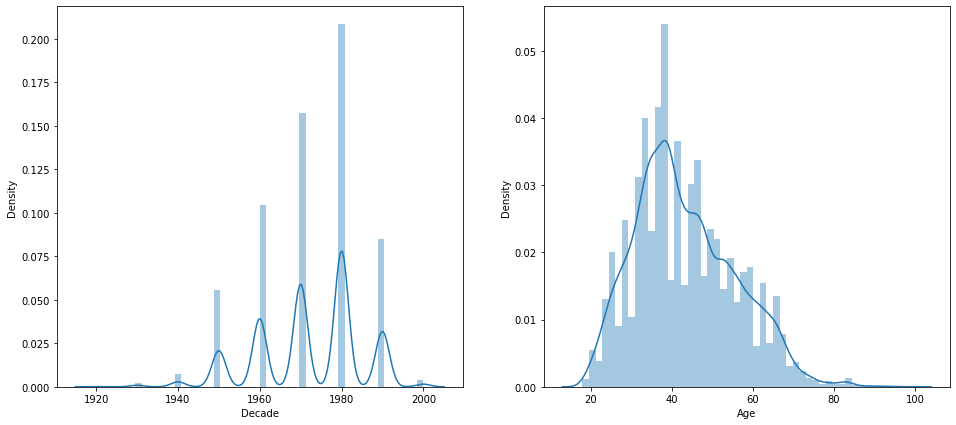

In [12]:
f, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.distplot(df.Decade, ax = ax[0])
ax[0].set_ylabel('Density')
sns.distplot(df.Age, ax = ax[1])

In [13]:
def percentstandardize_barplot(x, y, hue, data, ax=None, order=None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x=x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
          .reset_index(drop=True)
          .groupby([x])[hue]
          .value_counts(normalize=True)
          .rename('Percentage').mul(100)
          .reset_index()
          .sort_values(hue)))
    plt.title('Percentage Frequency of {} by {}'.format(hue, x))
    plt.ylabel('Percentage %')

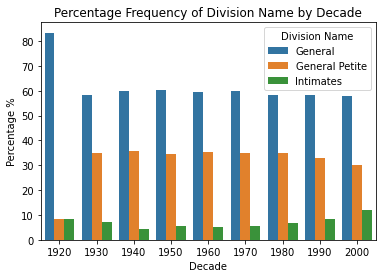

In [14]:
huevar = 'Division Name'
percentstandardize_barplot(x='Decade', y='Percentage', hue=huevar,data=df)

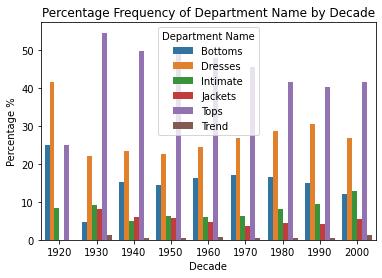

In [15]:
huevar = 'Department Name'
percentstandardize_barplot(x='Decade', y='Percentage', hue=huevar,data=df)

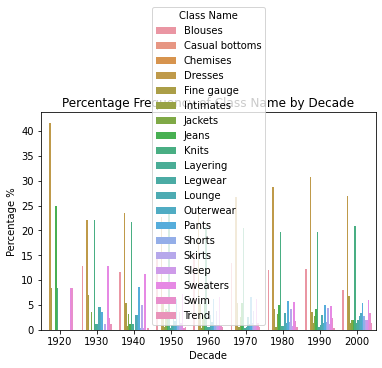

In [16]:
huevar = 'Class Name'
percentstandardize_barplot(x='Decade', y='Percentage', hue=huevar,data=df)

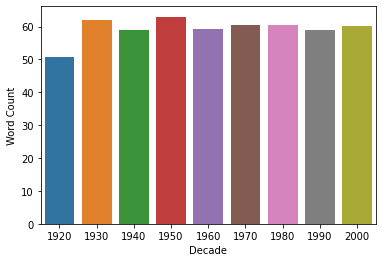

In [17]:
df2 = df.groupby(['Decade']).mean()
df2.reset_index(inplace=True)
sns.barplot(x='Decade', y = 'Word Count', data=df2)

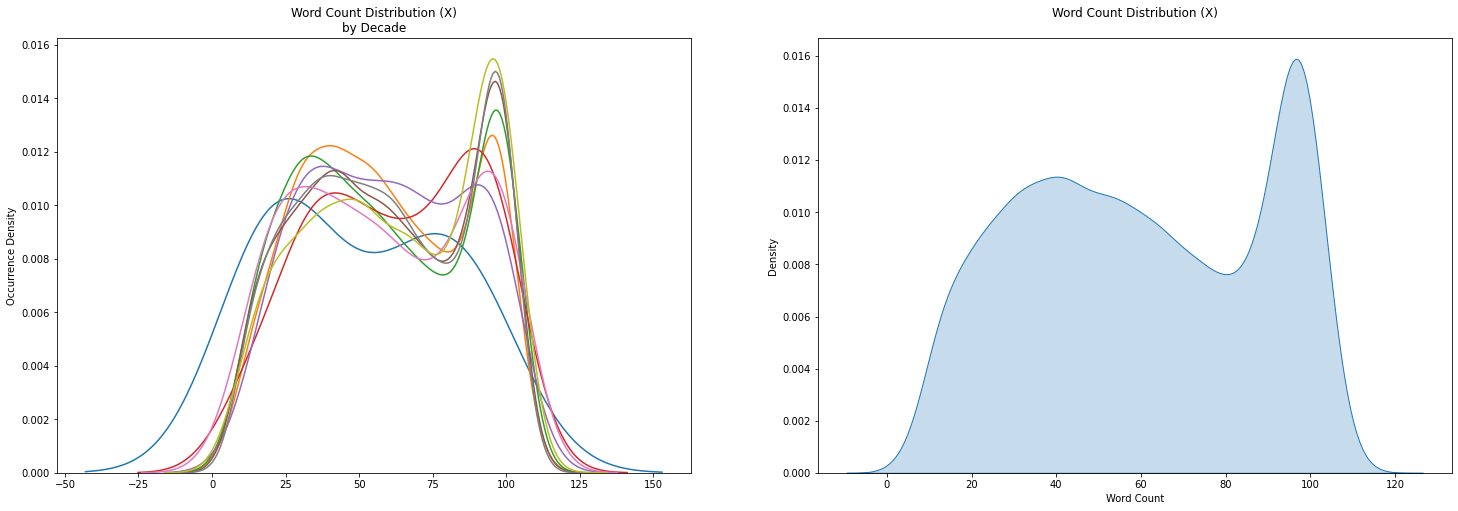


Total Word Count is: 1362913


count    22641.000000
mean        60.196679
std         28.534612
min          2.000000
25%         36.000000
50%         59.000000
75%         88.000000
max        115.000000
Name: Word Count, dtype: float64

In [18]:
f, axes = plt.subplots(1, 2, figsize=(25, 8), sharex=False)


for x in set(df['Decade'][df['Decade'].notnull()]):
    sns.kdeplot(df['Word Count'][df['Decade']==x], label=x, shade=False, ax=axes[0])
    axes[0].set_title('{} Distribution (X)\nby {}'.format('Word Count', 'Decade'))
axes[0].set_ylabel('Occurrence Density')
axes[0].set_xlabel('')

# Plot 4
axes[1].set_title('Word Count Distribution (X)\n')
sns.kdeplot(df['Word Count'],shade=True,ax=axes[1])

plt.show()

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
df['Word Count'].describe().T

# Text exploration

In [19]:
# Importing spacy
import spacy

df['cleaned']=df['Review Text'].apply(lambda x: x.lower())
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))


# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])


# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [20]:
df.head()

,Decade,Age,Title,Review Text,Division Name,Department Name,Class Name,temp,Text,Word Count,cleaned,lemmatized
0,1980,33,NaN,Absolutely wonderful - silky and sexy and comf...,Intimates,Intimate,Intimates,,"Title: , Division: Intimates, Department: Inti...",8,absolutely wonderful silky and sexy and comfor...,absolutely wonderful silky sexy comfortable
1,1980,34,NaN,Love this dress! it's sooo pretty. i happene...,General,Dresses,Dresses,,"Title: , Division: General, Department: Dresse...",62,love this dress its sooo pretty i happened to ...,love dress sooo pretty happen find store be gl...
2,1960,60,Some major design flaws,I had such high hopes for this dress and reall...,General,Dresses,Dresses,Some major design flaws,"Title: Some major design flaws, Division: Gene...",98,i had such high hopes for this dress and reall...,high hope dress want work initially order peti...
3,1970,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Bottoms,Pants,My favorite buy!,"Title: My favorite buy!, Division: General Pet...",22,i love love love this jumpsuit its fun flirty ...,love love love jumpsuit fun flirty fabulous ti...
4,1970,47,Flattering shirt,This shirt is very flattering to all due to th...,General,Tops,Blouses,Flattering shirt,"Title: Flattering shirt, Division: General, De...",36,this shirt is very flattering to all due to th...,shirt flattering adjustable tie perfect length...


# Feature Extraction

In [21]:
def get_avg_chars_in_word(text):
  if text:
    doc = nlp(text)
    total = 0
    for token in doc:
      total += len(token.text)
    return total // len(doc)
  else:
    return 0



,Decade,Age,Word Count,AvgCharsPerWord
0,1920,93.500000,50.666667,3.083333
1,1930,83.709302,62.023256,3.058140
2,1940,74.061372,59.007220,3.086643
3,1950,64.645097,62.986063,3.101045
4,1960,55.173626,59.162262,3.081660
5,1970,45.169705,60.367286,3.083801
6,1980,35.820085,60.338633,3.071542
7,1990,26.522135,59.077148,3.083984
8,2000,19.677852,60.140940,3.067114


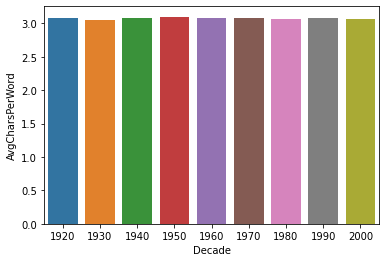

In [22]:
df['AvgCharsPerWord'] = df["Review Text"].apply(get_avg_chars_in_word)
df2 = df.groupby(['Decade']).mean()
df2.reset_index(inplace=True)
sns.barplot(x='Decade', y = 'AvgCharsPerWord', data=df2)
df2

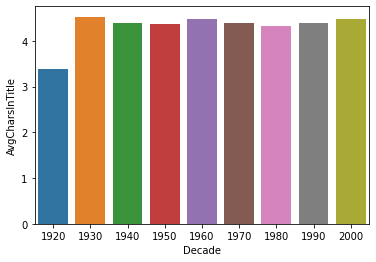

In [23]:
df['AvgCharsInTitle'] = df['Title'][df['Title'].notnull()].apply(get_avg_chars_in_word)

df2 = df.groupby(['Decade']).mean()
df2.reset_index(inplace=True)
sns.barplot(x='Decade', y = 'AvgCharsInTitle', data=df2)

In [24]:
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

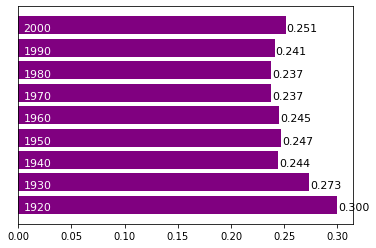

In [25]:
age_polarity_sorted=pd.DataFrame(df.groupby('Decade')['polarity'].mean())
polarity_graph=plt.barh(np.arange(len(age_polarity_sorted.index)),age_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,age_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,age_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

## simple classifier

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score


# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values for decades
df['label'] = labelencoder.fit_transform(df['Decade'])
num_of_labels = len(df['label'].unique())
classes = list(labelencoder.classes_)
df.head()

x_data = df["Review Text"]
y= df["label"]

count_vectorizer = CountVectorizer(max_features=5000,ngram_range=(1,2), stop_words = "english")

features = count_vectorizer.fit_transform(x_data)
count_vec_x = pd.DataFrame(
    features.todense(),
    columns=count_vectorizer.get_feature_names()
)
# cat_vec = pd.DataFrame()
# cat_vec['Division'] = labelencoder.fit_transform(df['Division Name'].map(str))
# cat_vec['Department'] = labelencoder.fit_transform(df['Department Name'].map(str))
# cat_vec['Class'] = labelencoder.fit_transform(df['Class Name'].map(str))

count_vec_x['Division'] = labelencoder.fit_transform(df['Division Name'].map(str))
count_vec_x['Department'] = labelencoder.fit_transform(df['Department Name'].map(str))
count_vec_x['Class'] = labelencoder.fit_transform(df['Class Name'].map(str))


from sklearn.model_selection import train_test_split
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(count_vec_x,y, test_size=0.2, random_state=42)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train_cv,y_train_cv)
y_pred = nb.predict(x_test_cv)
print("Score(F1):", f1_score(y_test_cv, y_pred, average='micro'))

Score(F1): 0.1686906601898874


# Word clouds

In [30]:
import matplotlib as mpl

stopwords = set(STOPWORDS)
size = (20, 10)

def cloud(text, title, stopwords=stopwords, size=size):
    mpl.rcParams['figure.figsize'] = (10.0, 10.0)
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.subplot.bottom'] = .1
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords).generate(str(text))
    
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50, color='y')
    plt.tight_layout()
    plt.savefig('{}.png'.format(title), format='png', dpi=300)
    plt.show()
    
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    mpl.style.use('ggplot')
    rslt.plot.bar(rot=0)
    
def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rlst = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    return rlst

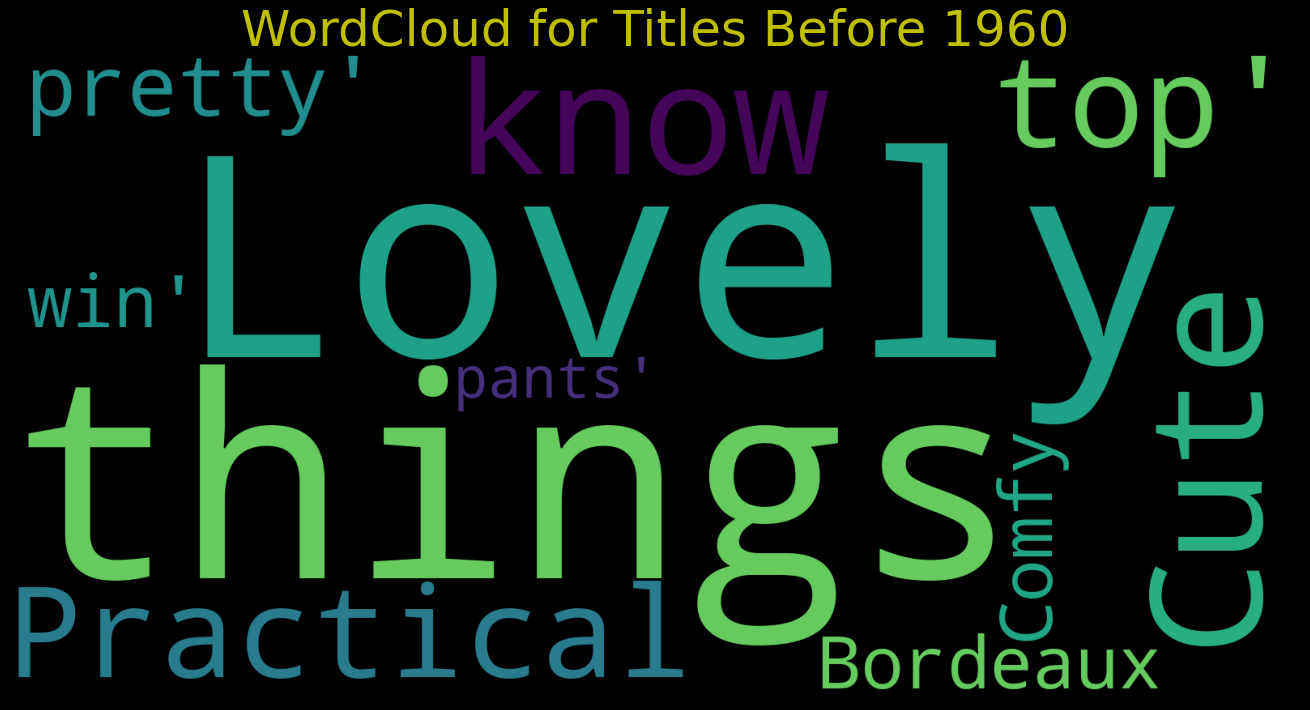

In [31]:
new_stop = set(STOPWORDS)
# Cloud
cloud(text=df.Title[df.Title.notnull()][df.Decade.astype(int) < 1960].astype(str).values,
      title='WordCloud for Titles Before 1960',
      stopwords=new_stop)

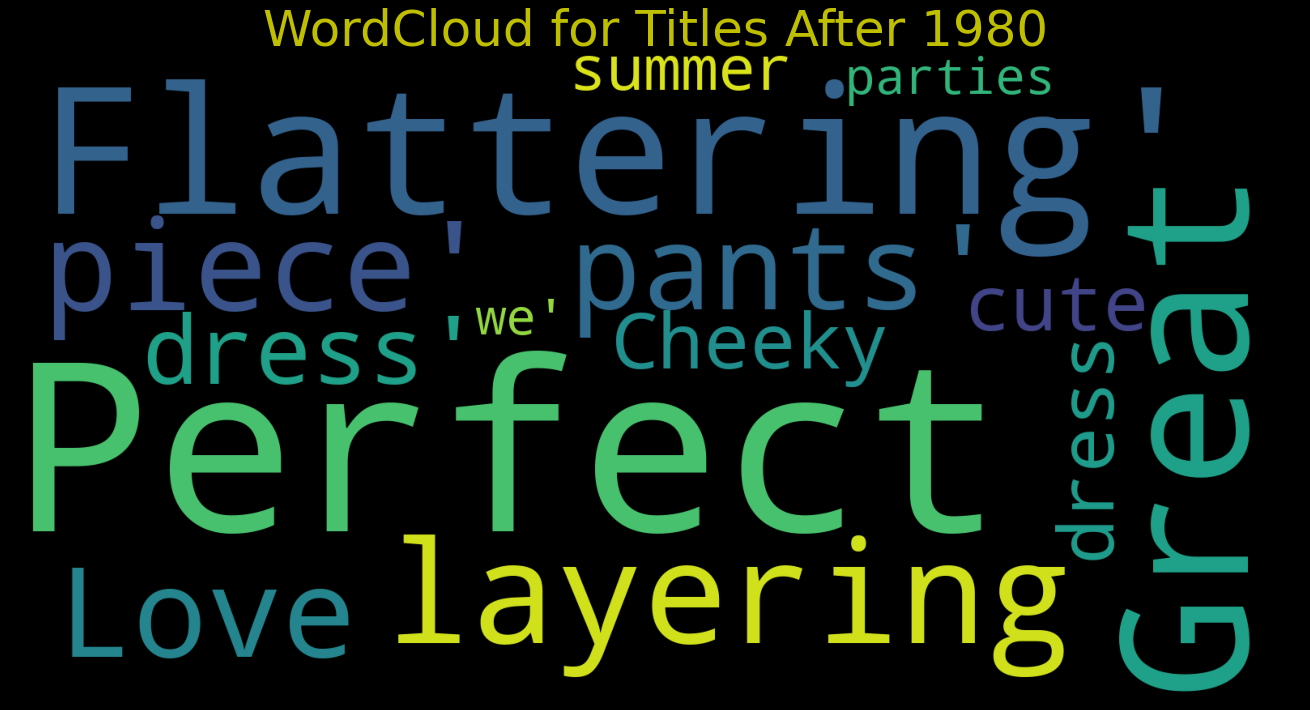

In [32]:
new_stop = set(STOPWORDS)
# Cloud
cloud(text=df.Title[df.Title.notnull()][df.Decade.astype(int) > 1980].astype(str).values,
      title='WordCloud for Titles After 1980',
      stopwords=new_stop)

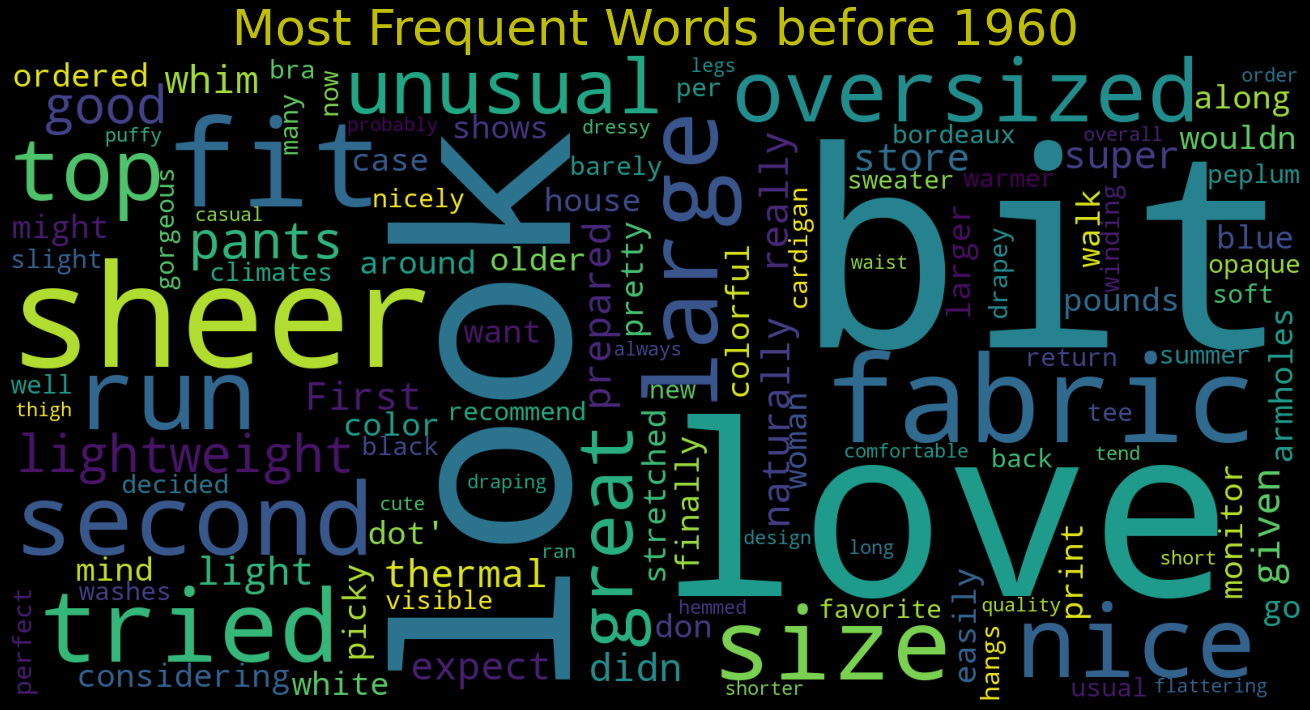

In [33]:
title ='Most Frequent Words before 1960'
temp = df['Review Text'][df.Decade.astype(int) < 1960]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

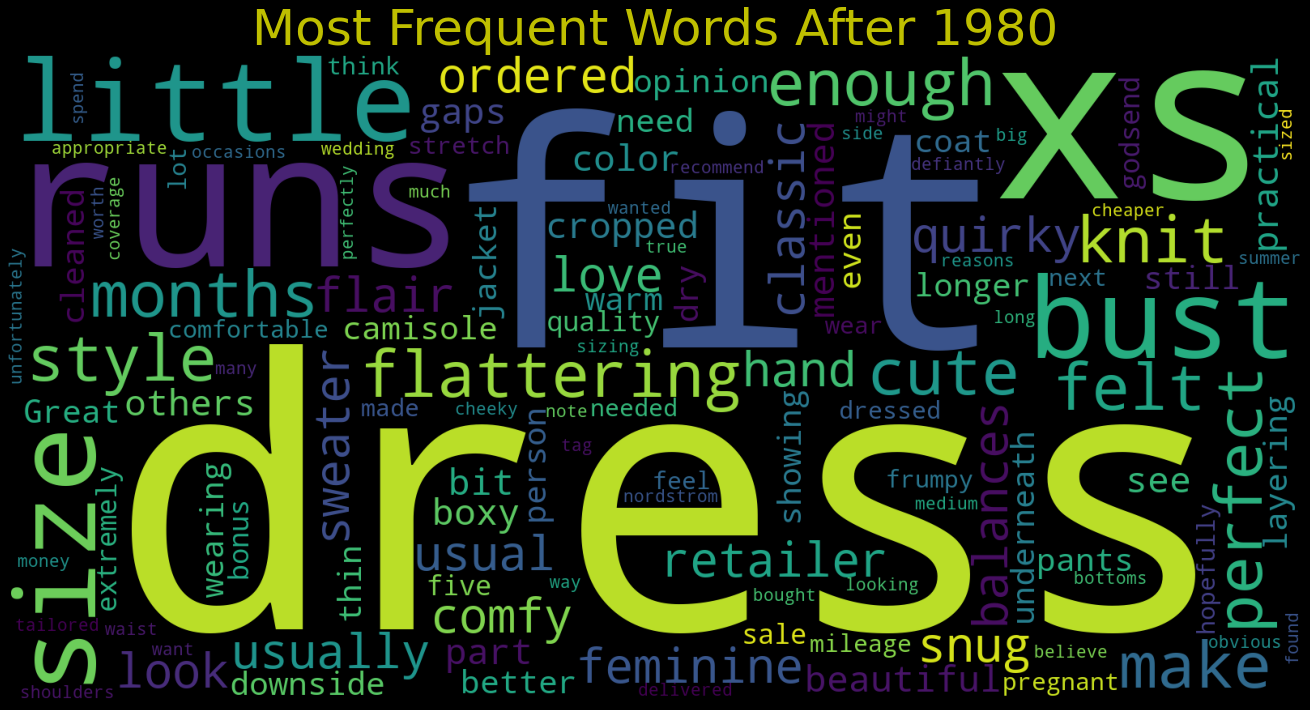

In [34]:
title ='Most Frequent Words After 1980'
temp = df['Review Text'][df.Decade.astype(int) > 1980]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)
# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)